# SuperNeuroABM Tutorial: Building Spiking Neural Networks

This tutorial demonstrates how to use SuperNeuroABM to create and simulate spiking neural networks with Leaky Integrate-and-Fire (LIF) neurons. We'll walk through the dual external synapses with dual somas example to illustrate the key concepts.

## Table of Contents
1. [Introduction to SuperNeuroABM](#introduction)
2. [LIF Neuron Model](#lif-model)
3. [Synapse Models](#synapse-models)
4. [Building a Simple Network](#simple-network)
5. [Dual External Synapses with Dual Somas](#dual-synapses-dual-somas)
6. [Running Simulations](#running-simulations)
7. [Analyzing Results](#analyzing-results)
8. [Visualization](#visualization)

## 1. Introduction to SuperNeuroABM {#introduction}

SuperNeuroABM is a framework for building and simulating spiking neural networks using agent-based modeling. It provides:
- Various neuron models (LIF, Izhikevich)
- Synaptic models with plasticity
- GPU acceleration support
- Flexible network topology creation

The framework is built on top of SAGESim and supports both CPU and GPU execution.

In [1]:
# Import necessary libraries
import sys
import os

# Add the parent directory to the Python path so we can import superneuroabm
sys.path.insert(0, os.path.abspath('..'))

# Add SAGESim to the Python path
sys.path.insert(0, '/home/xxz/SAGESim')

import numpy as np
import matplotlib.pyplot as plt
import csv

try:
    from superneuroabm.model import NeuromorphicModel
    print("Successfully imported superneuroabm!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure that:")
    print("1. SAGESim is available at /home/xxz/SAGESim")
    print("2. superneuroabm is in the parent directory")
    print("3. All dependencies are installed")
    raise

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")

Successfully imported superneuroabm!
All libraries imported successfully!


/home/xxz/miniconda3/envs/sna_dev/lib/python3.13/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


## 2. LIF Neuron Model {#lif-model}

The Leaky Integrate-and-Fire (LIF) neuron is a simplified model of biological neurons. It integrates incoming currents and fires a spike when the membrane potential crosses a threshold.

### LIF Neuron Equation
The membrane potential $V$ evolves according to:

$$C \frac{dV}{dt} = \frac{V_{rest} - V}{R} + I_{synapse} + I_{bias} + I_{input}$$

Where:
- $C$: Membrane capacitance (F)
- $R$: Membrane resistance (Ω)
- $V_{rest}$: Resting potential (mV)
- $I_{synapse}$: Synaptic input current (A)
- $I_{bias}$: Bias current (A)
- $I_{input}$: Direct input current (A)

When $V \geq V_{threshold}$, the neuron fires a spike and $V$ is reset to $V_{reset}$.

### LIF Neuron Parameters

In [11]:
# Define LIF neuron parameters
def create_lif_parameters():
    """
    Create standard LIF neuron parameters.
    
    Returns:
        list: Parameters for LIF neuron [C, R, vthr, tref, vrest, vreset, tref_allows_integration, I_in]
    """
    C = 10e-9          # Membrane capacitance (10 nF)
    R = 1e12           # Membrane resistance (1 TΩ)
    vthr = -45         # Spike threshold voltage (mV)
    tref = 5e-3        # Refractory period (5 ms)
    vrest = -60        # Resting potential (mV)
    vreset = -70       # Reset potential after spike (mV)
    tref_allows_integration = 1  # Allow integration during refractory period
    I_in = 0           # Direct input current (A)
    
    return [C, R, vthr, tref, vrest, vreset, tref_allows_integration, I_in]

# Display parameter values
lif_params = create_lif_parameters()
param_names = ['C (F)', 'R (Ω)', 'V_thr (mV)', 't_ref (s)', 'V_rest (mV)', 'V_reset (mV)', 'Ref_integration', 'I_in (A)']
print("LIF Neuron Parameters:")
print("=" * 40)
for name, value in zip(param_names, lif_params):
    print(f"{name:15}: {value}")

LIF Neuron Parameters:
C (F)          : 1e-08
R (Ω)          : 1000000000000.0
V_thr (mV)     : -45
t_ref (s)      : 0.005
V_rest (mV)    : -60
V_reset (mV)   : -70
Ref_integration: 1
I_in (A)       : 0


## 3. Synapse Models {#synapse-models}

Synapses connect neurons and transmit signals between them. SuperNeuroABM supports exponential synapses with the following dynamics:

### Exponential Synapse
The synaptic current follows:

$$I_{synapse}(t) = weight \cdot scale \cdot \exp\left(-\frac{t}{\tau_{fall}}\right)$$

Where:
- $weight$: Synaptic strength
- $scale$: Scaling factor
- $\tau_{fall}$: Decay time constant
- $delay$: Synaptic transmission delay

### Synapse Parameters

In [12]:
# Define synapse parameters
def create_synapse_parameters(weight=1.0, delay=1.0, tau_fall=1.0):
    """
    Create synapse parameters.
    
    Args:
        weight: Synaptic weight (strength)
        delay: Transmission delay (ms)
        tau_fall: Decay time constant (ms)
    
    Returns:
        list: Parameters for synapse [weight, delay, scale, tau_fall, tau_rise]
    """
    scale = 1.0        # Scaling factor
    tau_rise = 0       # Rise time constant (instantaneous)
    
    return [weight, delay, scale, tau_fall, tau_rise]

# Create different synapse types
strong_synapse = create_synapse_parameters(weight=2.0, delay=1.0, tau_fall=1.0)
weak_synapse = create_synapse_parameters(weight=1.0, delay=1.0, tau_fall=1.0)

print("Synapse Parameters:")
print("=" * 40)
print(f"Strong synapse: {strong_synapse}")
print(f"Weak synapse:   {weak_synapse}")

Synapse Parameters:
Strong synapse: [2.0, 1.0, 1.0, 1.0, 0]
Weak synapse:   [1.0, 1.0, 1.0, 1.0, 0]


## 4. Building a Simple Network {#simple-network}

Let's start by creating a simple network with one neuron and one external input synapse to understand the basics.

In [13]:
# Create a simple network with one neuron
def create_simple_network():
    """
    Create a simple network with one LIF neuron and one external synapse.
    
    Returns:
        tuple: (model, soma_id, synapse_id)
    """
    # Create model instance
    model = NeuromorphicModel()
    
    # Set global simulation parameters
    model.register_global_property("dt", 1e-1)  # Time step (100 μs)
    model.register_global_property("I_bias", 0)  # No bias current
    
    # Create LIF neuron parameters
    soma_parameters = create_lif_parameters()
    
    # Set initial internal state
    v = -60  # Initial membrane voltage (resting potential)
    tcount = 0  # Time counter
    tlast = 0  # Last spike time
    I_synapse = 0  # Initial synaptic current
    default_internal_state = [v, tcount, tlast, I_synapse]
    
    # Create LIF neuron
    soma_id = model.create_soma(
        breed="LIF_Soma",
        parameters=soma_parameters,
        default_internal_state=default_internal_state,
    )
    
    # Create external input synapse
    synapse_parameters = create_synapse_parameters(weight=2.0, delay=1.0, tau_fall=1.0)
    synapse_internal_state = [0.0]  # Initial synaptic current
    
    synapse_id = model.create_synapse(
        breed="Single_Exp_Synapse",
        pre_soma_id=np.nan,  # External input (no pre-synaptic neuron)
        post_soma_id=soma_id,
        parameters=synapse_parameters,
        default_internal_state=synapse_internal_state,
    )
    
    return model, soma_id, synapse_id

# Create and test simple network
simple_model, soma_0, syn_ext = create_simple_network()
print(f"Created simple network:")
print(f"  Soma ID: {soma_0}")
print(f"  Synapse ID: {syn_ext}")

Created simple network:
  Soma ID: 0
  Synapse ID: 1


## 5. Dual External Synapses with Dual Somas {#dual-synapses-dual-somas}

Now let's create the more complex network from the test case: dual external synapses feeding into one soma, which then connects to a second soma.

### Network Architecture
```
External Input A ──→ Synapse A ──┐
                                 ├──→ Soma 0 ──→ Synapse C ──→ Soma 1
External Input B ──→ Synapse B ──┘
```

This network demonstrates:
1. **Input integration**: Soma 0 integrates inputs from two external synapses
2. **Signal propagation**: Spikes from Soma 0 propagate to Soma 1
3. **Synaptic dynamics**: Different synaptic weights and timing effects

In [5]:
def create_dual_synapse_dual_soma_network():
    """
    Create the dual external synapses with dual somas network.
    
    Returns:
        tuple: (model, soma_0, soma_1, syn_ext_A, syn_ext_B, syn_int_C)
    """
    # Create model instance
    model = NeuromorphicModel()
    
    # Set global simulation parameters
    model.register_global_property("dt", 1e-1)  # Time step (100 μs)
    model.register_global_property("I_bias", 0)  # No bias current
    
    # Create LIF neuron parameters
    soma_parameters = create_lif_parameters()
    
    # Set initial internal state for neurons
    v = -60  # Initial membrane voltage (resting potential)
    tcount = 0  # Time counter
    tlast = 0  # Last spike time
    I_synapse = 0  # Initial synaptic current
    default_internal_state = [v, tcount, tlast, I_synapse]
    
    # Create two LIF neurons
    soma_0 = model.create_soma(
        breed="LIF_Soma",
        parameters=soma_parameters,
        default_internal_state=default_internal_state,
    )
    
    soma_1 = model.create_soma(
        breed="LIF_Soma",
        parameters=soma_parameters,
        default_internal_state=default_internal_state,
    )
    
    # Create synaptic parameters
    # Synapse A: stronger weight
    synapse_parameters_A = create_synapse_parameters(weight=2.0, delay=1.0, tau_fall=1.0)
    # Synapse B: weaker weight
    synapse_parameters_B = create_synapse_parameters(weight=1.0, delay=1.0, tau_fall=1.0)
    # Synapse C: internal connection
    synapse_parameters_C = create_synapse_parameters(weight=1.0, delay=1.0, tau_fall=1.0)
    
    # Initial synaptic current
    synapse_internal_state = [0.0]
    
    # Create external input synapse A (stronger input to soma_0)
    syn_ext_A = model.create_synapse(
        breed="Single_Exp_Synapse",
        pre_soma_id=np.nan,  # External input
        post_soma_id=soma_0,
        parameters=synapse_parameters_A,
        default_internal_state=synapse_internal_state,
    )
    
    # Create external input synapse B (weaker input to soma_0)
    syn_ext_B = model.create_synapse(
        breed="Single_Exp_Synapse",
        pre_soma_id=np.nan,  # External input
        post_soma_id=soma_0,
        parameters=synapse_parameters_B,
        default_internal_state=synapse_internal_state,
    )
    
    # Create internal synapse C (soma_0 -> soma_1)
    syn_int_C = model.create_synapse(
        breed="Single_Exp_Synapse",
        pre_soma_id=soma_0,
        post_soma_id=soma_1,
        parameters=synapse_parameters_C,
        default_internal_state=synapse_internal_state,
    )
    
    return model, soma_0, soma_1, syn_ext_A, syn_ext_B, syn_int_C

# Create the network
model, soma_0, soma_1, syn_ext_A, syn_ext_B, syn_int_C = create_dual_synapse_dual_soma_network()

print(f"Created dual synapse dual soma network:")
print(f"  Soma 0 ID: {soma_0}")
print(f"  Soma 1 ID: {soma_1}")
print(f"  External Synapse A ID: {syn_ext_A}")
print(f"  External Synapse B ID: {syn_ext_B}")
print(f"  Internal Synapse C ID: {syn_int_C}")

Created dual synapse dual soma network:
  Soma 0 ID: 0
  Soma 1 ID: 1
  External Synapse A ID: 2
  External Synapse B ID: 3
  Internal Synapse C ID: 4


## 6. Running Simulations {#running-simulations}

Now let's run a simulation with carefully designed input patterns to demonstrate the network behavior.

In [6]:
def run_simulation():
    """
    Run simulation with dual external inputs.
    
    Returns:
        tuple: Simulation results and network components
    """
    # Initialize the simulation environment
    model.setup(use_gpu=False)  # Use CPU for this tutorial
    
    # Define input spike patterns
    # Synapse A receives early, strong spikes
    spikes_A = [(2, 1), (10, 1), (20, 1)]  # (time_tick, spike_value)
    
    # Synapse B receives delayed, weaker spikes that can overlap with A
    spikes_B = [(5, 1), (12, 1), (25, 1)]  # (time_tick, spike_value)
    
    print("Input spike patterns:")
    print(f"  Synapse A (strong): {spikes_A}")
    print(f"  Synapse B (weak):   {spikes_B}")
    
    # Inject spikes into external synapses
    for spike in spikes_A:
        model.add_spike(synapse_id=syn_ext_A, tick=spike[0], value=spike[1])
    
    for spike in spikes_B:
        model.add_spike(synapse_id=syn_ext_B, tick=spike[0], value=spike[1])
    
    # Run simulation
    simulation_ticks = 100  # Run for 100 time steps
    model.simulate(ticks=simulation_ticks, update_data_ticks=1)
    
    # Extract simulation results
    results = {
        'soma_0_states': np.array(model.get_internal_states_history(agent_id=soma_0)),
        'soma_1_states': np.array(model.get_internal_states_history(agent_id=soma_1)),
        'synapse_A_states': np.array(model.get_internal_states_history(agent_id=syn_ext_A)),
        'synapse_B_states': np.array(model.get_internal_states_history(agent_id=syn_ext_B)),
        'synapse_C_states': np.array(model.get_internal_states_history(agent_id=syn_int_C)),
        'soma_0_spikes': model.get_spike_times(soma_id=soma_0),
        'soma_1_spikes': model.get_spike_times(soma_id=soma_1),
        'simulation_ticks': simulation_ticks,
        'spikes_A': spikes_A,
        'spikes_B': spikes_B
    }
    
    return results

# Run the simulation
results = run_simulation()

print("\nSimulation completed!")
print(f"Soma 0 spike times: {results['soma_0_spikes']}")
print(f"Soma 1 spike times: {results['soma_1_spikes']}")
print(f"Total simulation ticks: {results['simulation_ticks']}")

Input spike patterns:
  Synapse A (strong): [(2, 1), (10, 1), (20, 1)]
  Synapse B (weak):   [(5, 1), (12, 1), (25, 1)]

Simulation completed!
Soma 0 spike times: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Soma 1 spike times: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Total simulation ticks: 100


## 7. Analyzing Results {#analyzing-results}

Let's analyze the simulation results to understand the network behavior.

In [7]:
def analyze_results(results):
    """
    Analyze simulation results and print key metrics.
    
    Args:
        results: Dictionary containing simulation results
    """
    print("Network Analysis")
    print("=" * 50)
    
    # Analyze soma responses
    soma_0_spikes = results['soma_0_spikes']
    soma_1_spikes = results['soma_1_spikes']
    
    print(f"Soma 0:")
    print(f"  Number of spikes: {len(soma_0_spikes)}")
    print(f"  Spike times: {soma_0_spikes}")
    
    print(f"\nSoma 1:")
    print(f"  Number of spikes: {len(soma_1_spikes)}")
    print(f"  Spike times: {soma_1_spikes}")
    
    # Analyze synaptic currents
    max_synA_current = np.max(np.abs(results['synapse_A_states'][:, 0]))
    max_synB_current = np.max(np.abs(results['synapse_B_states'][:, 0]))
    max_synC_current = np.max(np.abs(results['synapse_C_states'][:, 0]))
    
    print(f"\nSynaptic Currents (max absolute values):")
    print(f"  Synapse A (strong): {max_synA_current:.2e}")
    print(f"  Synapse B (weak):   {max_synB_current:.2e}")
    print(f"  Synapse C (internal): {max_synC_current:.2e}")
    
    # Analyze membrane potentials
    soma_0_v = results['soma_0_states'][:, 0]
    soma_1_v = results['soma_1_states'][:, 0]
    
    print(f"\nMembrane Potentials:")
    print(f"  Soma 0 - Min: {np.min(soma_0_v):.2f} mV, Max: {np.max(soma_0_v):.2f} mV")
    print(f"  Soma 1 - Min: {np.min(soma_1_v):.2f} mV, Max: {np.max(soma_1_v):.2f} mV")
    
    # Analyze input-output relationship
    input_events = len(results['spikes_A']) + len(results['spikes_B'])
    output_events = len(soma_0_spikes) + len(soma_1_spikes)
    
    print(f"\nInput-Output Analysis:")
    print(f"  Total input events: {input_events}")
    print(f"  Total output events: {output_events}")
    print(f"  Network gain: {output_events/input_events:.2f}")
    
    return {
        'soma_0_spike_count': len(soma_0_spikes),
        'soma_1_spike_count': len(soma_1_spikes),
        'max_currents': [max_synA_current, max_synB_current, max_synC_current],
        'network_gain': output_events/input_events
    }

# Analyze the results
analysis = analyze_results(results)

Network Analysis
Soma 0:
  Number of spikes: 97
  Spike times: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Soma 1:
  Number of spikes: 96
  Spike times: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Synaptic Currents (max absolute values):
  Synapse A (strong): 3.00e+00
  Synapse B (weak):   1.48e+00
  Synapse C (internal): 1

## 8. Visualization {#visualization}

Let's create comprehensive visualizations to understand the network dynamics.

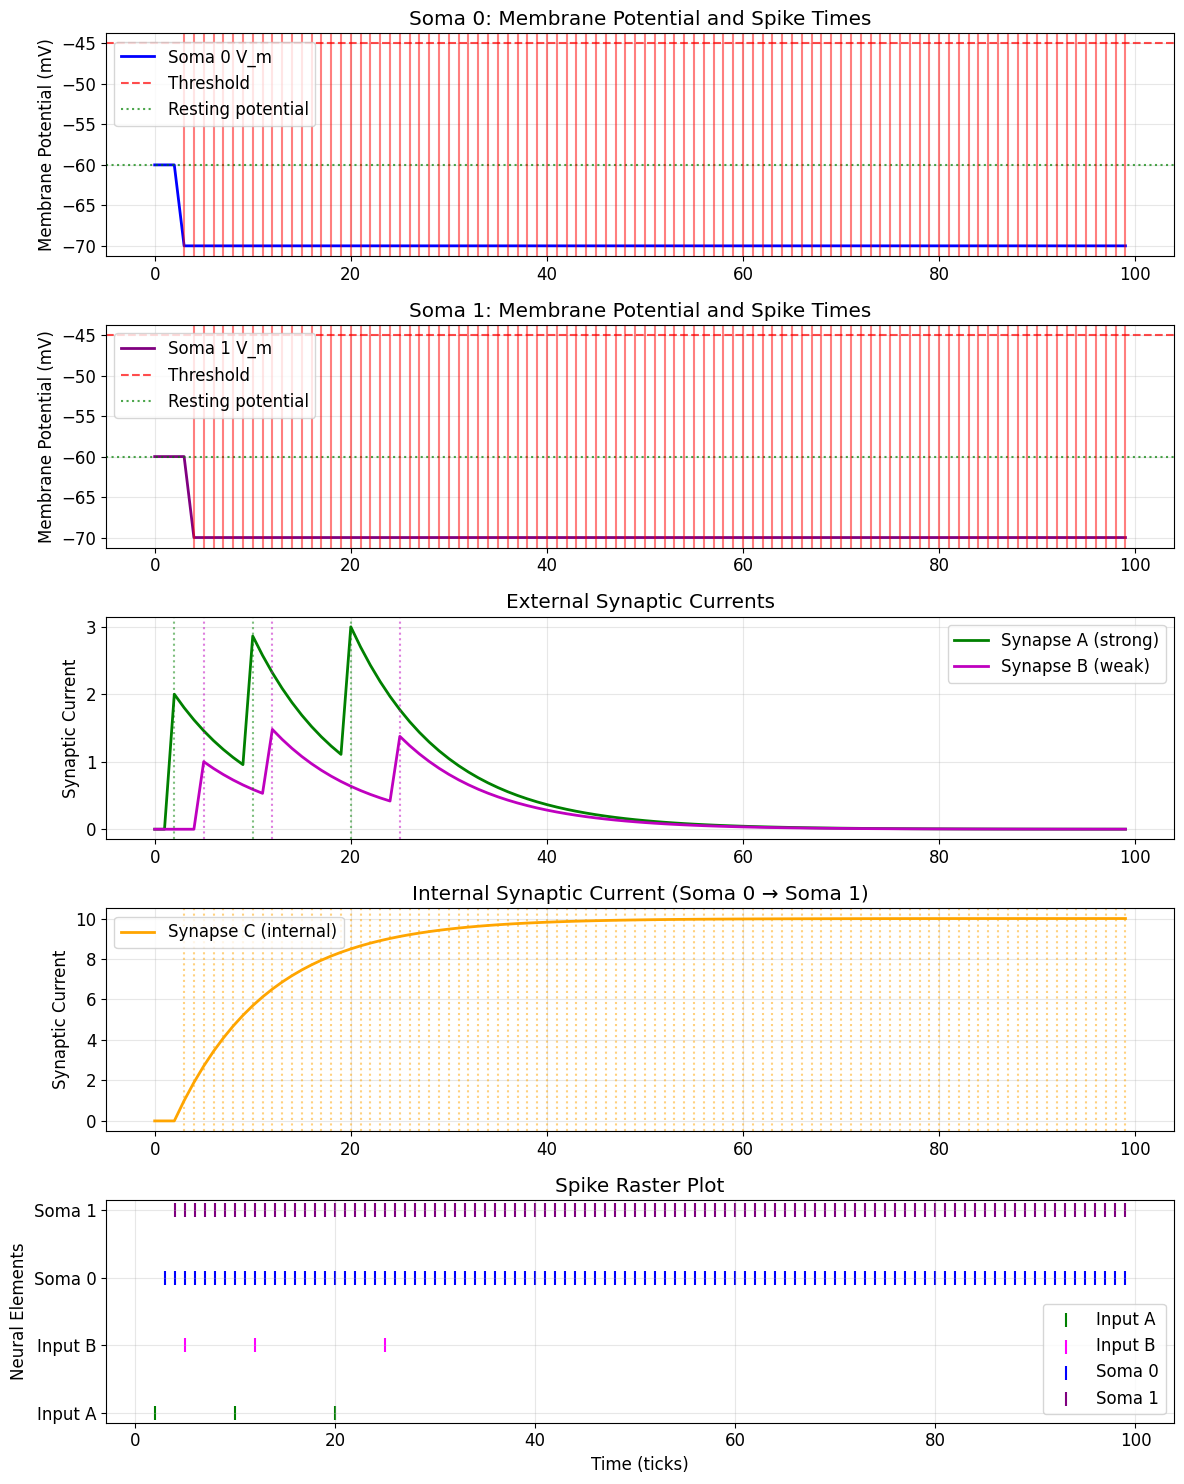

In [8]:
def create_comprehensive_visualization(results):
    """
    Create comprehensive visualization of the simulation results.
    
    Args:
        results: Dictionary containing simulation results
    """
    # Create figure with subplots
    fig, axes = plt.subplots(5, 1, figsize=(12, 15))
    
    # Time vector
    time_ticks = np.arange(results['simulation_ticks'])
    
    # Plot 1: Soma 0 membrane potential
    ax1 = axes[0]
    ax1.plot(time_ticks, results['soma_0_states'][:, 0], 'b-', linewidth=2, label='Soma 0 V_m')
    ax1.axhline(y=-45, color='r', linestyle='--', alpha=0.7, label='Threshold')
    ax1.axhline(y=-60, color='g', linestyle=':', alpha=0.7, label='Resting potential')
    
    # Mark spike times
    for spike_time in results['soma_0_spikes']:
        ax1.axvline(x=spike_time, color='r', alpha=0.5, linestyle='-')
    
    ax1.set_ylabel('Membrane Potential (mV)')
    ax1.set_title('Soma 0: Membrane Potential and Spike Times')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Soma 1 membrane potential
    ax2 = axes[1]
    ax2.plot(time_ticks, results['soma_1_states'][:, 0], 'purple', linewidth=2, label='Soma 1 V_m')
    ax2.axhline(y=-45, color='r', linestyle='--', alpha=0.7, label='Threshold')
    ax2.axhline(y=-60, color='g', linestyle=':', alpha=0.7, label='Resting potential')
    
    # Mark spike times
    for spike_time in results['soma_1_spikes']:
        ax2.axvline(x=spike_time, color='r', alpha=0.5, linestyle='-')
    
    ax2.set_ylabel('Membrane Potential (mV)')
    ax2.set_title('Soma 1: Membrane Potential and Spike Times')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Synaptic currents A and B
    ax3 = axes[2]
    ax3.plot(time_ticks, results['synapse_A_states'][:, 0], 'g-', linewidth=2, label='Synapse A (strong)')
    ax3.plot(time_ticks, results['synapse_B_states'][:, 0], 'm-', linewidth=2, label='Synapse B (weak)')
    
    # Mark input spike times
    for spike_time, _ in results['spikes_A']:
        ax3.axvline(x=spike_time, color='g', alpha=0.5, linestyle=':')
    for spike_time, _ in results['spikes_B']:
        ax3.axvline(x=spike_time, color='m', alpha=0.5, linestyle=':')
    
    ax3.set_ylabel('Synaptic Current')
    ax3.set_title('External Synaptic Currents')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Internal synaptic current C
    ax4 = axes[3]
    ax4.plot(time_ticks, results['synapse_C_states'][:, 0], 'orange', linewidth=2, label='Synapse C (internal)')
    
    # Mark soma 0 spike times (which drive synapse C)
    for spike_time in results['soma_0_spikes']:
        ax4.axvline(x=spike_time, color='orange', alpha=0.5, linestyle=':')
    
    ax4.set_ylabel('Synaptic Current')
    ax4.set_title('Internal Synaptic Current (Soma 0 → Soma 1)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Raster plot of all spikes
    ax5 = axes[4]
    
    # Input spikes
    input_A_times = [spike[0] for spike in results['spikes_A']]
    input_B_times = [spike[0] for spike in results['spikes_B']]
    
    ax5.scatter(input_A_times, [0] * len(input_A_times), c='green', s=100, marker='|', label='Input A')
    ax5.scatter(input_B_times, [0.5] * len(input_B_times), c='magenta', s=100, marker='|', label='Input B')
    
    # Output spikes
    ax5.scatter(results['soma_0_spikes'], [1] * len(results['soma_0_spikes']), c='blue', s=100, marker='|', label='Soma 0')
    ax5.scatter(results['soma_1_spikes'], [1.5] * len(results['soma_1_spikes']), c='purple', s=100, marker='|', label='Soma 1')
    
    ax5.set_xlabel('Time (ticks)')
    ax5.set_ylabel('Neural Elements')
    ax5.set_title('Spike Raster Plot')
    ax5.set_yticks([0, 0.5, 1, 1.5])
    ax5.set_yticklabels(['Input A', 'Input B', 'Soma 0', 'Soma 1'])
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create comprehensive visualization
fig = create_comprehensive_visualization(results)

### Understanding the Results

The visualization shows several key aspects of the network behavior:

1. **Input Integration**: Soma 0 receives inputs from both Synapse A (strong) and Synapse B (weak). The membrane potential shows how these inputs are integrated over time.

2. **Synaptic Dynamics**: The exponential decay of synaptic currents is clearly visible. Synapse A produces larger currents due to its higher weight.

3. **Spike Propagation**: When Soma 0 fires, it activates Synapse C, which then influences Soma 1's membrane potential.

4. **Temporal Dynamics**: The timing of inputs affects the network response. Closely spaced inputs can sum to produce larger responses.

5. **Threshold Dynamics**: Neurons only fire when their membrane potential crosses the threshold (-45 mV), after which they reset to the reset potential.

## Additional Visualizations

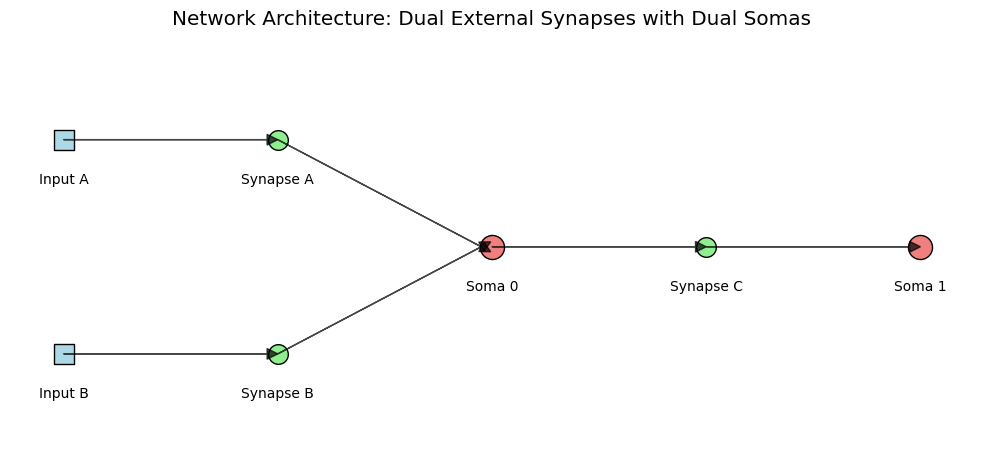

In [9]:
def create_network_diagram():
    """
    Create a simple network diagram showing the connectivity.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Define positions
    positions = {
        'Input A': (0, 1),
        'Input B': (0, -1),
        'Synapse A': (2, 1),
        'Synapse B': (2, -1),
        'Soma 0': (4, 0),
        'Synapse C': (6, 0),
        'Soma 1': (8, 0)
    }
    
    # Draw nodes
    for name, (x, y) in positions.items():
        if 'Input' in name:
            ax.scatter(x, y, s=200, c='lightblue', marker='s', edgecolors='black')
        elif 'Synapse' in name:
            ax.scatter(x, y, s=200, c='lightgreen', marker='o', edgecolors='black')
        else:  # Soma
            ax.scatter(x, y, s=300, c='lightcoral', marker='o', edgecolors='black')
        
        ax.text(x, y-0.3, name, ha='center', va='top', fontsize=10)
    
    # Draw connections
    connections = [
        ('Input A', 'Synapse A'),
        ('Input B', 'Synapse B'),
        ('Synapse A', 'Soma 0'),
        ('Synapse B', 'Soma 0'),
        ('Soma 0', 'Synapse C'),
        ('Synapse C', 'Soma 1')
    ]
    
    for start, end in connections:
        x1, y1 = positions[start]
        x2, y2 = positions[end]
        ax.arrow(x1, y1, x2-x1-0.1, y2-y1, head_width=0.1, head_length=0.1, 
                fc='black', ec='black', alpha=0.7)
    
    ax.set_xlim(-0.5, 8.5)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.set_title('Network Architecture: Dual External Synapses with Dual Somas')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create network diagram
network_fig = create_network_diagram()

## Summary and Key Takeaways

This tutorial demonstrated how to use SuperNeuroABM to create and simulate spiking neural networks:

### Key Concepts Covered:

1. **LIF Neuron Model**: Understanding membrane dynamics, thresholds, and refractory periods
2. **Synaptic Models**: Exponential synapses with different weights and time constants
3. **Network Construction**: Creating neurons and connecting them with synapses
4. **Simulation**: Running time-stepped simulations with external inputs
5. **Analysis**: Extracting and interpreting simulation results
6. **Visualization**: Creating comprehensive plots to understand network behavior

### SuperNeuroABM Features:

- **Flexible Architecture**: Easy to create complex network topologies
- **Multiple Neuron Types**: LIF and Izhikevich neurons supported
- **Synaptic Plasticity**: STDP and other learning rules available
- **GPU Acceleration**: Can run on GPU for large-scale simulations
- **Comprehensive Monitoring**: Track all internal states and spike trains

### Next Steps:

1. **Experiment with Parameters**: Try different neuron and synapse parameters
2. **Add More Neurons**: Scale up to larger networks
3. **Implement Learning**: Add synaptic plasticity mechanisms
4. **GPU Acceleration**: Run simulations on GPU for better performance
5. **Custom Step Functions**: Create your own neuron and synapse models

This framework provides a solid foundation for exploring spiking neural network dynamics and developing neuromorphic computing applications.

In [10]:
# Save simulation data for further analysis
def save_simulation_data(results, filename='tutorial_simulation_data.csv'):
    """
    Save simulation data to CSV file for further analysis.
    
    Args:
        results: Dictionary containing simulation results
        filename: Output filename
    """
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write header
        writer.writerow([
            'Time_Tick',
            'Soma_0_Membrane_Potential',
            'Soma_1_Membrane_Potential',
            'Synapse_A_Current',
            'Synapse_B_Current',
            'Synapse_C_Current'
        ])
        
        # Write data
        for i in range(results['simulation_ticks']):
            writer.writerow([
                i,
                results['soma_0_states'][i, 0],
                results['soma_1_states'][i, 0],
                results['synapse_A_states'][i, 0],
                results['synapse_B_states'][i, 0],
                results['synapse_C_states'][i, 0]
            ])
    
    print(f"Simulation data saved to {filename}")

# Save the data
save_simulation_data(results)

Simulation data saved to tutorial_simulation_data.csv
